In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
words = open('./data/names', 'r').read().splitlines()
for i, w in enumerate(words):
    words[i] = w.lower().replace(' ','').replace("'",'').replace('-','').strip()
len(words)

7944

In [4]:
words[::500]

['abagael',
 'benedetta',
 'claresta',
 'eilis',
 'glory',
 'jonell',
 'liliane',
 'melody',
 'prissie',
 'stacy',
 'geeta',
 'clinten',
 'giovanne',
 'lawerence',
 'piggy',
 'tann']

In [5]:
vocab = sorted(list(set(''.join(words))))
vocab_size = len(vocab) + 1
stoi = {s: i+1 for i, s in enumerate(vocab)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [6]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([44659, 3]) torch.Size([44659])
torch.Size([5539, 3]) torch.Size([5539])
torch.Size([5631, 3]) torch.Size([5631])


In [7]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/(n_embd * block_size)**0.5 # * 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01  # scale this aswell to get small logits
b2 = torch.randn(vocab_size,                      generator=g) * 0  # we don't actually want to add random bias to logits at initialization

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [8]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  break

      0/ 200000: 3.3049


In [9]:
# by the first loss, we can see, that our initialization is very poor
# basically we can calculate the initial loss for untrained network
# in out case the base prediction will be uniform distribution for all hcars in vocab
# so we would expect 1/27.0 probability of each char
-torch.tensor(1/27.0).log()

tensor(3.2958)

In [10]:
# so we wanna our logits to be roughly zero to have the uniform distribution and therefore low initial loss

In [11]:
# the second problem is the values of h
h

tensor([[-0.6834, -0.5239,  0.3475,  ...,  0.9779,  0.0868,  0.6649],
        [-0.9933,  0.9378,  0.8176,  ...,  0.3291, -0.6041,  0.9122],
        [-0.9866, -0.5663, -0.9997,  ..., -0.0749,  0.7560, -0.6215],
        ...,
        [-0.7382, -0.8751, -0.9191,  ..., -0.9845,  0.6010,  0.0531],
        [-0.9836,  0.7083, -0.0528,  ..., -0.1275,  0.9647,  0.9718],
        [-0.9836,  0.7083, -0.0528,  ..., -0.1275,  0.9647,  0.9718]],
       grad_fn=<TanhBackward0>)

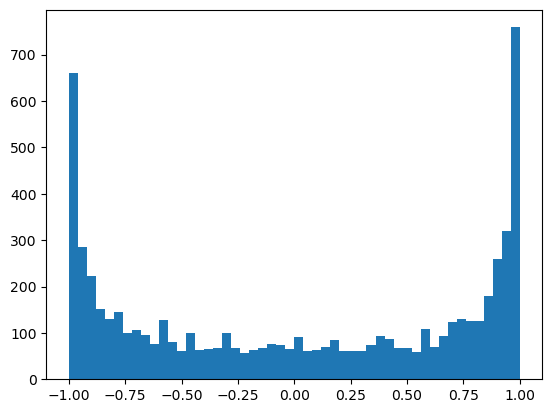

In [12]:
# we have a lot of -1/1 values in out activations
# this means that we are saturate this values -> the input to the tanh have high magnitudes 
plt.hist(h.view(-1).tolist(), bins=50);

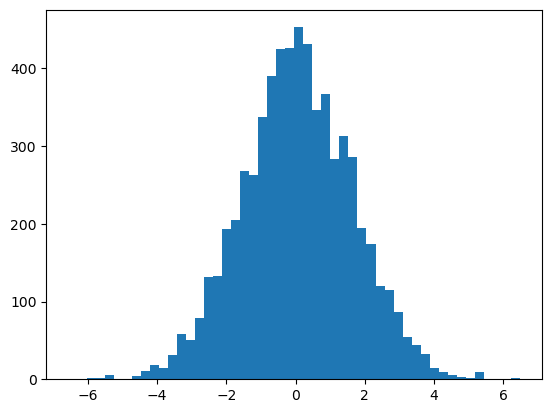

In [13]:
plt.hist(hpreact.view(-1).tolist(), bins=50);

In [14]:
# we see very broad distribution

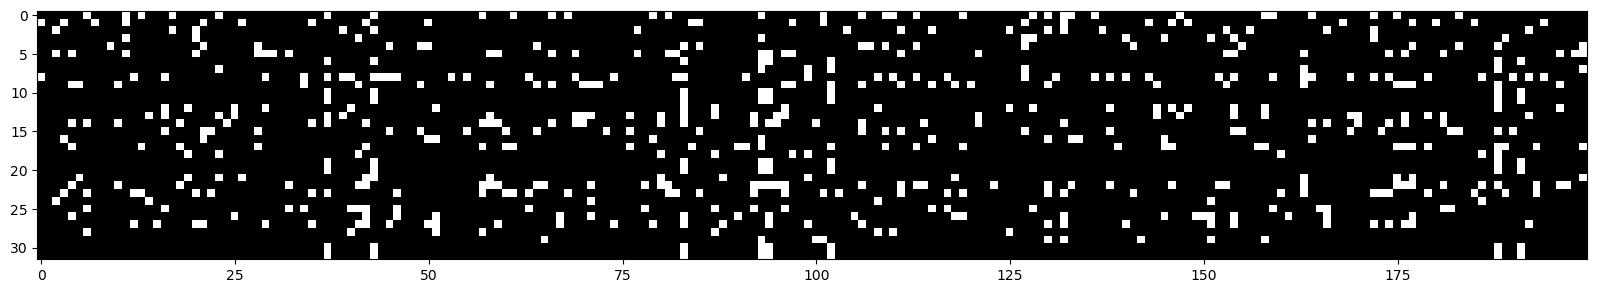

In [15]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

In [16]:
# we can see a lot of white bits, this is means that we have a lot of saturated neurons at initialization
# IMPORTANT: if we have the entire column in white then this particular neuron will be the 'dead' neuron
# the gradient never flows past them and it's never be able to learn

# the dead neuron can appear right after initialization, or meybe appeared in training phase

# so because of many saturated neurons at the init phase, our NN will be training slower, because not all gradients will be flow

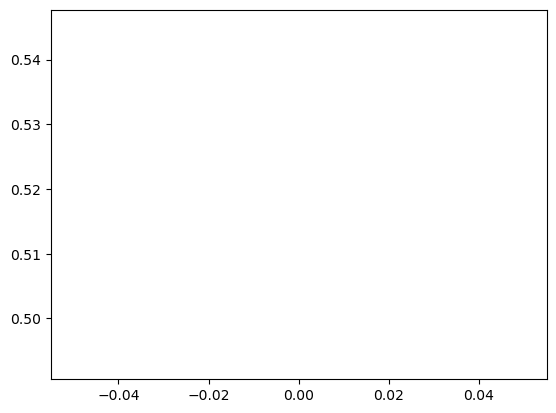

In [17]:
plt.plot(lossi)

tensor(-0.0004) tensor(1.0124)
tensor(0.0043) tensor(3.1822)


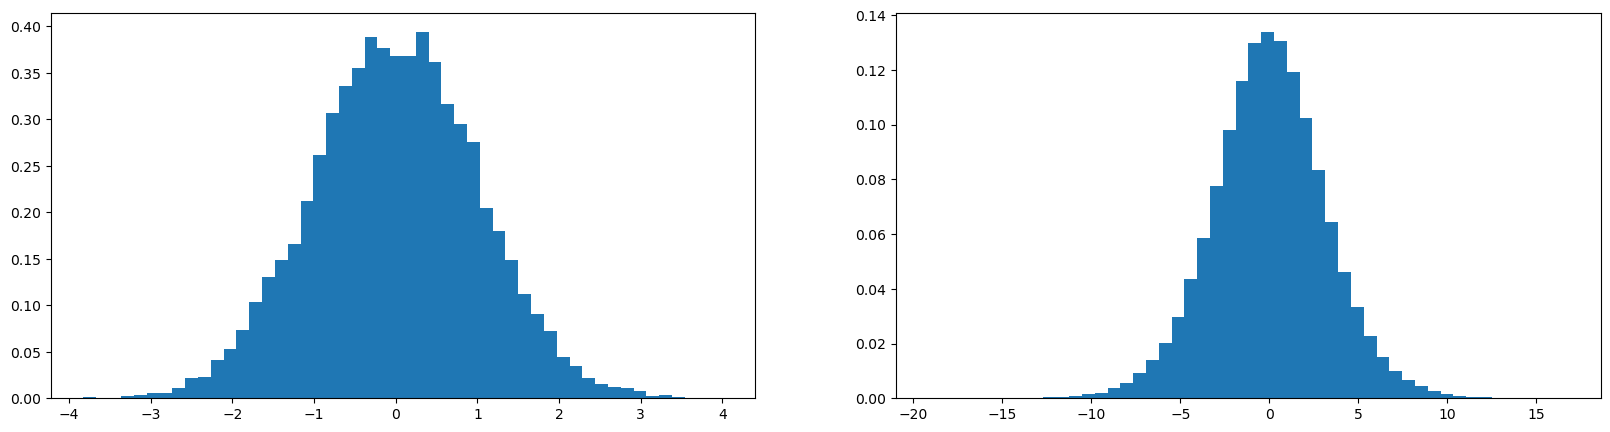

In [18]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1), bins=50, density=True);
plt.subplot(122)
plt.hist(y.view(-1), bins=50, density=True);

In [19]:
# we see that out gaussian is spreading after multiplication by 3 times
# the formula for independent rv:
# var(x*y) = mean(x)^2 * var(y) + mean(y)^2 * var(x) + var(x) * var(y)

# how do we scale this weights (x) to preserve the distribution of y?
# so mathematically is: 1/sqrt(f_in)

tensor(0.0113) tensor(1.0031)
tensor(-0.0007) tensor(0.9918)


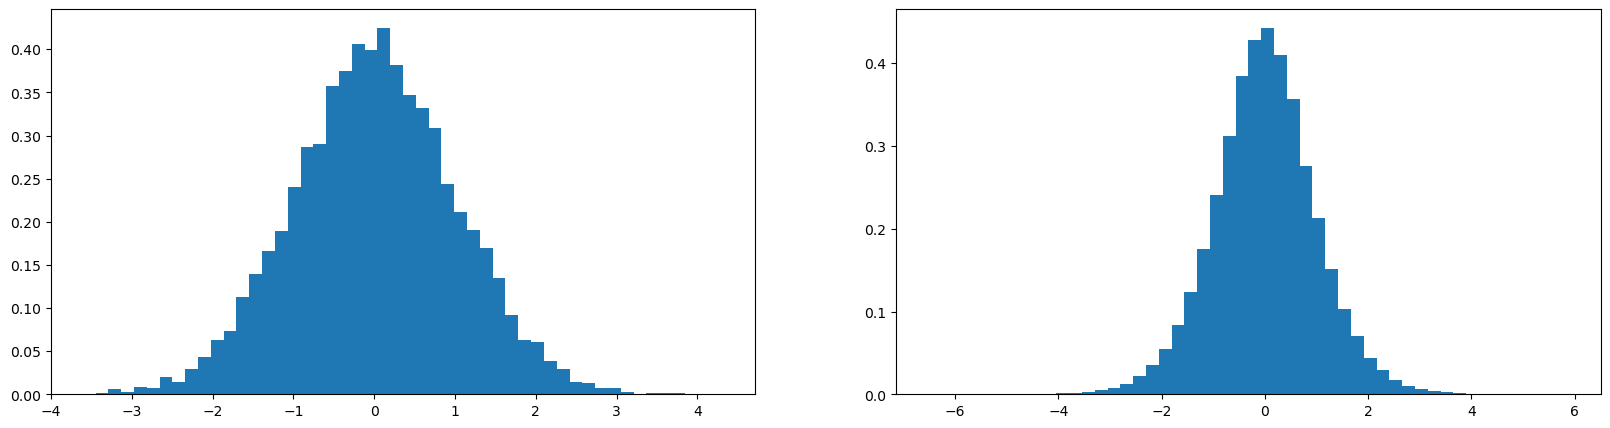

In [20]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1), bins=50, density=True);
plt.subplot(122)
plt.hist(y.view(-1), bins=50, density=True);

In [21]:
# the Kaiming He provide the initialization of
# from standard normal distribution with factor of sqrt(2)/sqrt(f_in) - for ReLU (so our normal distribtion has std=sqrt(2)/sqrt(f_in))

# the factor for different activations is different
# for ReLU is sqrt(2), for linear is 1, for tanh is 5/3, for sigmoid is 1

# so the normalization for the forward pass and the backward pass is quite similar for this case
# so, this kaiming initialization is implement  in pytorch 

In [22]:
# nowadays we don't need to initializt the NN exactly right
# because of some modern innovations:
# residual connections, normalazations (batch, layer)
# much better optimizers (RMsProp, Adam) 

### BatchNorm

In [23]:
# batch normalization made it possible to train very deep NN  quite reliably adn it basically fust worked
# so all we want is to make the pre activation values to have distribution with std=1 and mean=0

In [29]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/(n_embd * block_size)**0.5 # * 0.2
# b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01  # scale this aswell to get small logits
b2 = torch.randn(vocab_size,                      generator=g) * 0  # we don't actually want to add random bias to logits at initialization

bngains = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.zeros((1, n_hidden))

parameters = [C, W1, W2, b2, bngains, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [30]:
# so we don't want our preactivation to have the exact mean=0 and std=1 (at least for the batch)
# we want this dustribution have possibility to change for better results (according to the backprop)
# in order to do this we introducing the component `scale and shift`
# \gamma * y + \beta (at initialization \gamma = 1 and \beta = 0)
# and out NN learn now have the ability to adapt the normalization 

In [31]:
# as the NN become deeper, it's more harder to tune the weights of it to have a distribtuion of mean=0 and std=1
# so the batchnorm is helpful in this situations (so just sprincle the batchnorms at some layers of NN)
# and the batchnorm is sighnificantly stabilize the train process

In [32]:
# when using the batchnorm we couple out entities in batch and now the individual entity now dependent on all other vectors in batch (both in forward and backward) 
# therefore we adding some noise in our NN - and it's actually good in NN training 
# because it acts like regularizer

# there are normalization in which this property (coupling the vectors in batch) doesn't exist: layernormalization, instancenormalization, groupnormalization

In [33]:
# same optimization as last time
max_steps = 50000
batch_size = 64
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 # + b1 # hidden layer pre-activation
  # Batch normalization 
  bnmeani = hpreact.mean(dim=0, keepdim=True)
  bnstdi = hpreact.std(dim=0, keepdim=True)
  hpreact = bngains * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  # break

      0/  50000: 3.3069
  10000/  50000: 2.3139
  20000/  50000: 1.8767
  30000/  50000: 2.0386
  40000/  50000: 1.7542


In [34]:
# we need to use estimated mean and std from the train data at inference stage
# the simple case is calculate it's after training over the whole training dataset
# but it's add one stage after the tarining, so it's more appropriate to
# calculate the mean during training in running maner

# what's important it's that running mean don't update with gradient-based method, but
# it's updated beside the training and we should use torch.no_grad when updating it

# so we are very hopeful that bnmean_running and bnstd_running will be very similar to the 
# bnmean and bnstd we calculated in nex cell and therefore we don't need this stage

In [35]:
# two more notes about batchnorm
# 1. add the epsilon in the divisor part with bnstd
# 2. be careful with adding bias before batch norm (it's ). Because batchnorm has it's own bias and there is no need to add bias before it

In [ ]:
# advice for batchnorm:
# try to avoid batchnorm as much as possible (because the fact that it's coupling the instances in batch is so bad and generate more bugs)
# in recent DL the groupnorm and layernorm are more common and less prone to bugs than a batchnorm

In [36]:
# calibrate batch at the end of the training
with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    emb_cat = emb.view(emb.shape[0], -1)
    hpreact = emb_cat @ W1 + b1
    # measure the mean and std entire all train dataset
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)
    

In [44]:
# compare bn mean stats
print('Mean diffs')
with torch.no_grad():
    for bnmeani_explicit, bnmeani_running in zip(bnmean[0,:10], bnmean_running[0,:10]):
        print(f'{abs(bnmeani_explicit - bnmeani_running):.3f}')

Mean diffs
0.020
0.016
0.016
0.032
0.010
0.036
0.043
0.026
0.044
0.012


In [43]:
# compare bn std stats
print('Std diffs')
with torch.no_grad():
    for bnstdi_explicit, bnstdi_running in zip(bnstd[0,:10], bnstd_running[0,:10]):
        print(f'{abs(bnstdi_explicit - bnstdi_running):.3f}')

Std diffs
0.021
0.024
0.007
0.006
0.019
0.023
0.019
0.017
0.027
0.011


In [45]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngains * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.8818577527999878
val 2.0860865116119385


In [30]:
# sampling from the model
for _ in range(25):

    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

anda.
landrene.
alina.
edougie.
natolina.
rangi.
russuelle.
kevynny.
aud.
timplermanna.
tamman.
gante.
jordie.
edity.
tedrancesy.
baldonnazya.
carennya.
lutandy.
vina.
davin.
sayre.
vickiolas.
mitrice.
jolette.
mary.


### PyTorch-ifyng the code

In [95]:
class Linear():

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn(size=(fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(size=(fan_out, )) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([self.bias] if self.bias is not None else [])
    

class BatchNorm1d():

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(size=(dim, ))
        self.beta = torch.zeros(size=(dim, ))
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(size=(dim, ))
        self.running_var = torch.ones(size=(dim, ))

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        self.out = self.gamma * (x - xmean) / torch.sqrt(xvar + self.eps) + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    

class Tanh():

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

### Manual calibrated NN (without BN)

In [75]:
n_embd = 10
n_hidden = 100

C = torch.randn(size=(vocab_size, n_embd))
layers = [
    Linear(n_embd*block_size, n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden), Tanh(),
    Linear(         n_hidden, vocab_size),
]

# reducing the weights of the last layer (logits)
# in order to have more uniform distribution at initialization
with torch.no_grad():
    layers[-1].weight *= 0.1
    # all other layers apply more gain (because we use Tanh - the gain is 5/3)
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

46497


In [76]:
max_steps = 50000
batch_size = 64
lossi = []
ud = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], size=(batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad()  # for debug
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.001
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std()/p.data.std()).log10().item() for p in parameters])

    if i > 1000:
        break  # for debug

      0/  50000: 3.294770


layer 1 (      Tanh): mean +0.00, std 0.77, saturated: 23.16%
layer 3 (      Tanh): mean -0.01, std 0.71, saturated: 12.66%
layer 5 (      Tanh): mean +0.02, std 0.71, saturated: 9.70%
layer 7 (      Tanh): mean -0.05, std 0.72, saturated: 10.44%
layer 9 (      Tanh): mean -0.01, std 0.71, saturated: 10.50%


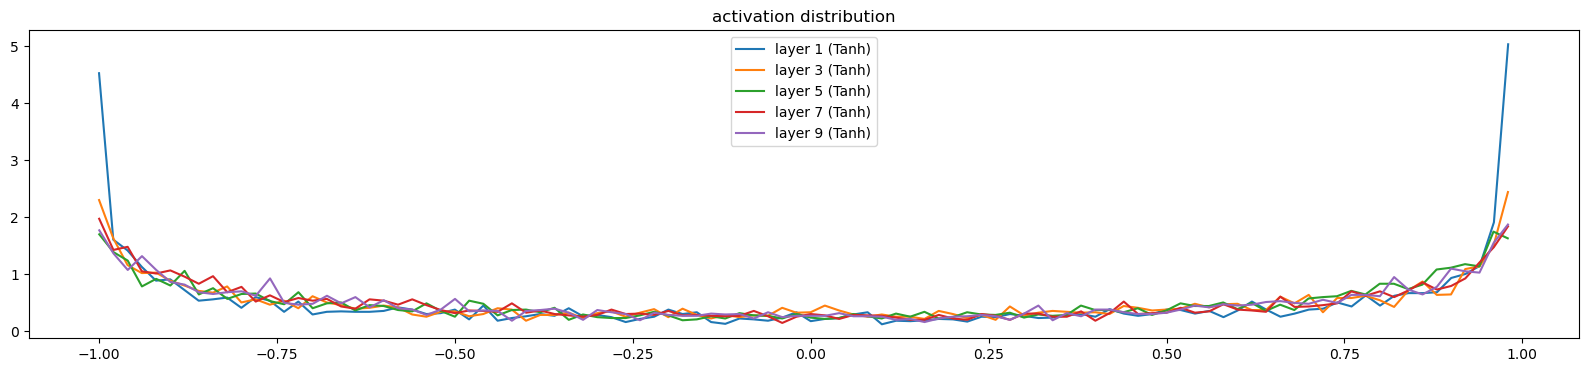

In [77]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution');

layer 1 (      Tanh): mean -0.000041, std 1.827402e-03
layer 3 (      Tanh): mean -0.000017, std 1.770448e-03
layer 5 (      Tanh): mean +0.000014, std 1.735827e-03
layer 7 (      Tanh): mean -0.000045, std 1.545538e-03
layer 9 (      Tanh): mean -0.000023, std 1.239177e-03


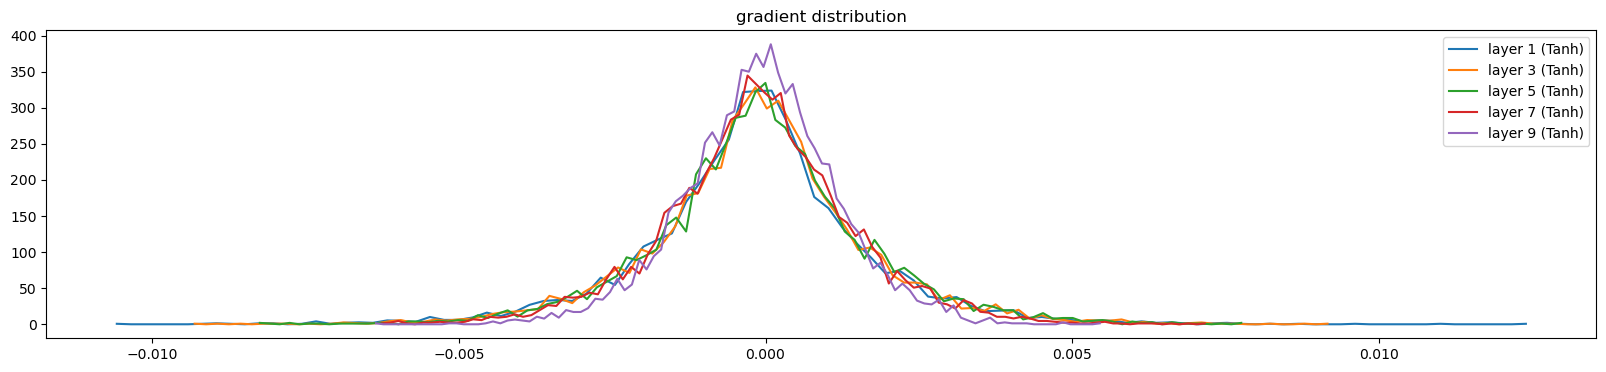

In [78]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('gradient distribution');

In [73]:
# so we want roughly the same statistics through all layer (both data and grad)
# in order to reach this, we need to set the right initialization for our layers
# but as NN become deeper is so hard to do this because we may have different layers and activations

weight   (27, 10) | mean +0.000064 | std 8.070829e-03 | grad:data ratio 7.967431e-03
weight  (30, 100) | mean -0.000138 | std 8.838176e-03 | grad:data ratio 2.956896e-02
weight (100, 100) | mean +0.000038 | std 6.941976e-03 | grad:data ratio 4.109874e-02
weight (100, 100) | mean +0.000001 | std 5.882223e-03 | grad:data ratio 3.488524e-02
weight (100, 100) | mean +0.000088 | std 5.730168e-03 | grad:data ratio 3.407139e-02
weight (100, 100) | mean +0.000048 | std 4.503951e-03 | grad:data ratio 2.680902e-02
weight  (100, 27) | mean +0.000000 | std 1.721419e-02 | grad:data ratio 2.160230e-01


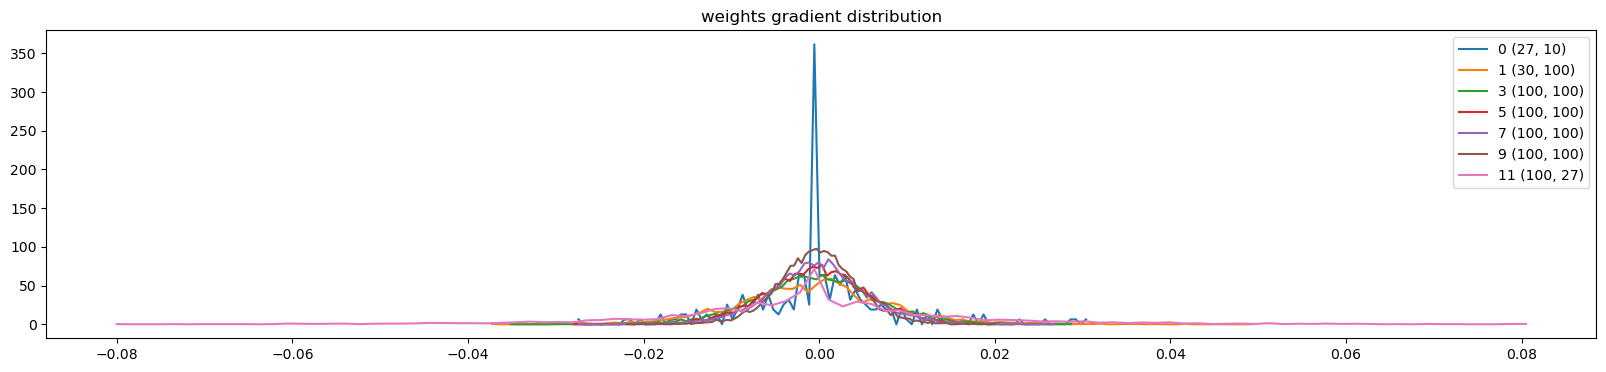

In [79]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:  # considering only weights from linear layers + embedding layer
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

In [ ]:
# gradient to data ratio very important metric, because we updating the data with some step of gradient
# and it's important to don't have extreme ratios

In [ ]:
# at the last graph we see that each layer has it's own gradient magnitude (and distribution as well),
# that means that for example the last layer has grads 10x greater that other layers
# that meand that we will train the last layer 10x time faster than others (only at first iteration/init)
# but after each train iterations the distribution will be converging

# so what's important it's that it will be great if we consider the gradient distribution (particulary the std) of each layer separately
# when we are updating our weights
# exactly this doing the modern optimizers (like Adam)

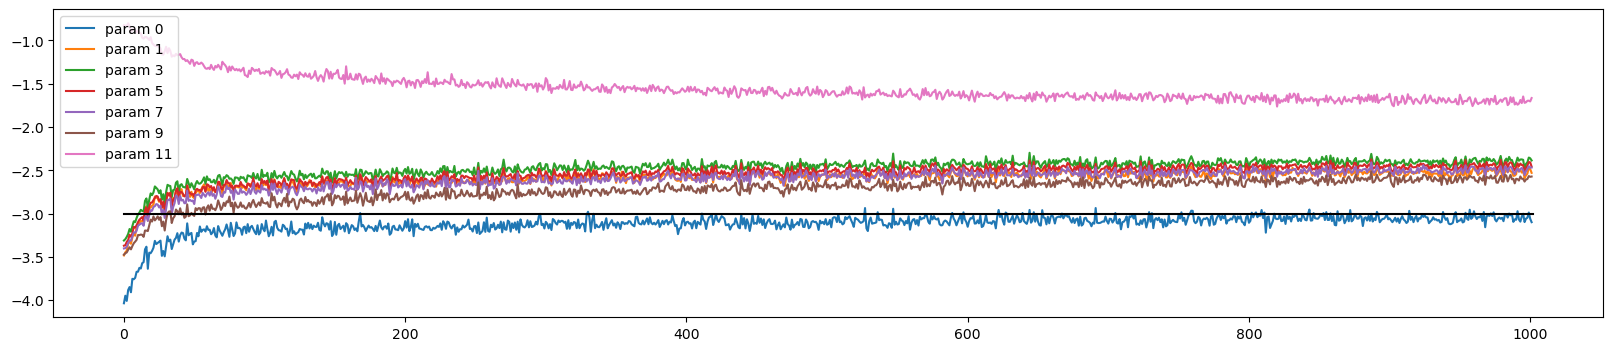

In [80]:
# another informative graph is grad update to data ratio (more informative)
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [83]:
# this is good graph because it can show us the speed of learning of our layers
# by looking at this graph we can determine that some layers are learning slow/fast
# and we can change the learning rate in order to get the oprimal ratio (~1e-3)

# so it's very useful in practice
# and Andrej highly recommend this

### NN with BN

In [ ]:
# typical the BN is inserted between linear layer and activation
# it's also a good practice to insert the BN after the last layer aswell

In [103]:
n_embd = 10
n_hidden = 100

C = torch.randn(size=(vocab_size, n_embd))
layers = [
    Linear(n_embd*block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden, vocab_size), BatchNorm1d(vocab_size),
]

# reducing the weights of the last layer (logits)
# in order to have more uniform distribution at initialization
with torch.no_grad():
    layers[-1].gamma *= 0.1
    # all other layers apply more gain (because we use Tanh - the gain is 5/3)
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 0.2 # 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

47551


In [104]:
max_steps = 50000
batch_size = 64
lossi = []
ud = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], size=(batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad()  # for debug
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.001
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std()/p.data.std()).log10().item() for p in parameters])

    if i > 1000:
        break  # for debug

      0/  50000: 3.313429


layer 2 (      Tanh): mean +0.00, std 0.63, saturated: 3.97%
layer 5 (      Tanh): mean -0.00, std 0.65, saturated: 3.08%
layer 8 (      Tanh): mean -0.00, std 0.67, saturated: 2.00%
layer 11 (      Tanh): mean +0.00, std 0.67, saturated: 1.38%
layer 14 (      Tanh): mean -0.00, std 0.68, saturated: 0.81%


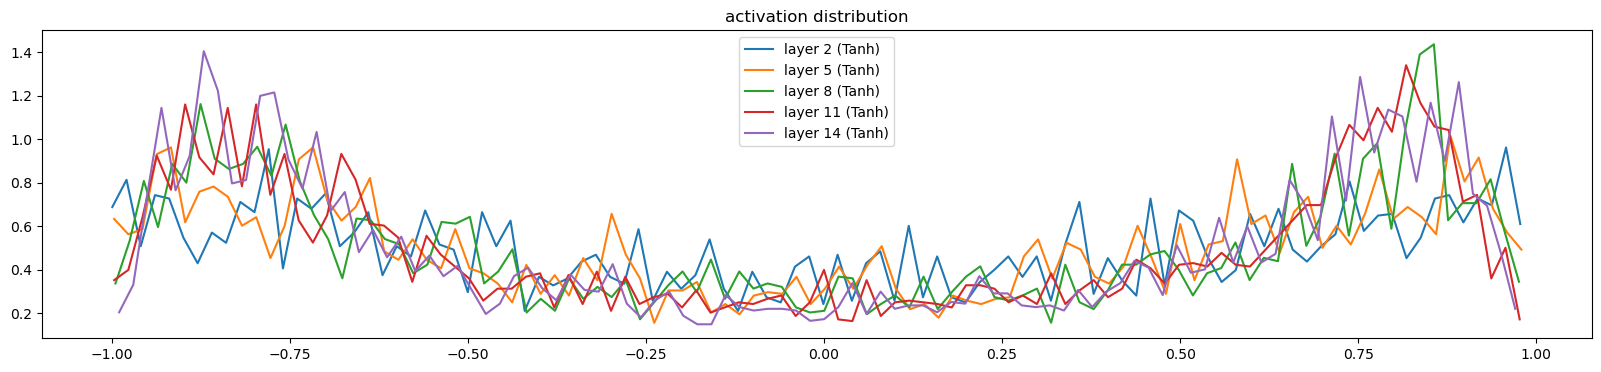

In [105]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution');

layer 2 (      Tanh): mean +0.000000, std 8.822947e-04
layer 5 (      Tanh): mean +0.000000, std 8.321677e-04
layer 8 (      Tanh): mean -0.000000, std 7.390398e-04
layer 11 (      Tanh): mean +0.000000, std 7.269261e-04
layer 14 (      Tanh): mean -0.000000, std 8.023693e-04


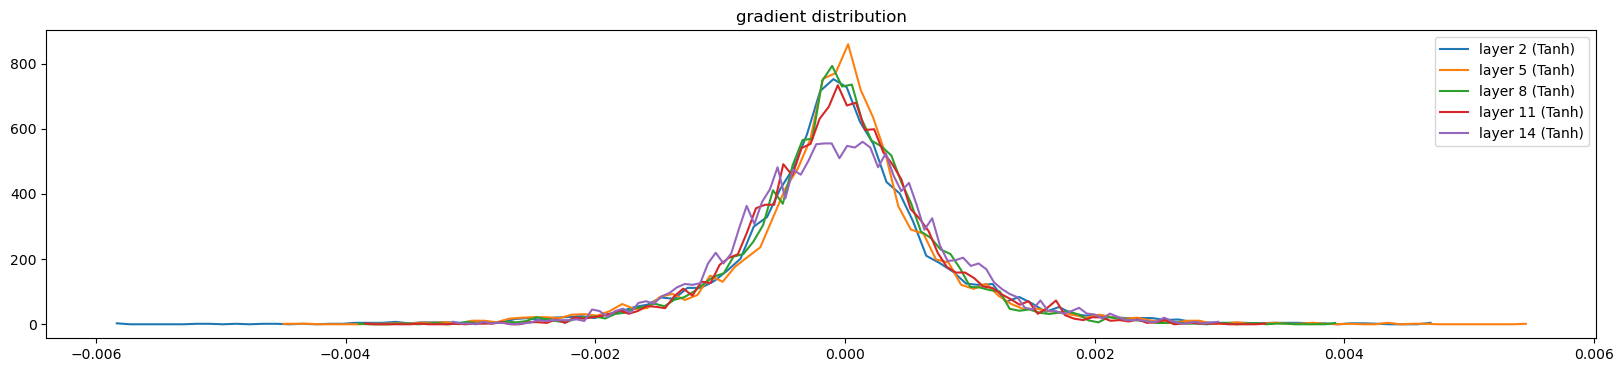

In [106]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('gradient distribution');

weight   (27, 10) | mean +0.000000 | std 4.720269e-03 | grad:data ratio 4.551272e-03
weight  (30, 100) | mean +0.000446 | std 1.415770e-02 | grad:data ratio 2.319147e-01
weight (100, 100) | mean -0.000062 | std 7.408159e-03 | grad:data ratio 2.302063e-01
weight (100, 100) | mean +0.000048 | std 6.632599e-03 | grad:data ratio 2.222970e-01
weight (100, 100) | mean +0.000064 | std 5.967415e-03 | grad:data ratio 2.090812e-01
weight (100, 100) | mean +0.000032 | std 6.549582e-03 | grad:data ratio 2.337208e-01
weight  (100, 27) | mean +0.000181 | std 1.614552e-02 | grad:data ratio 3.543591e-01


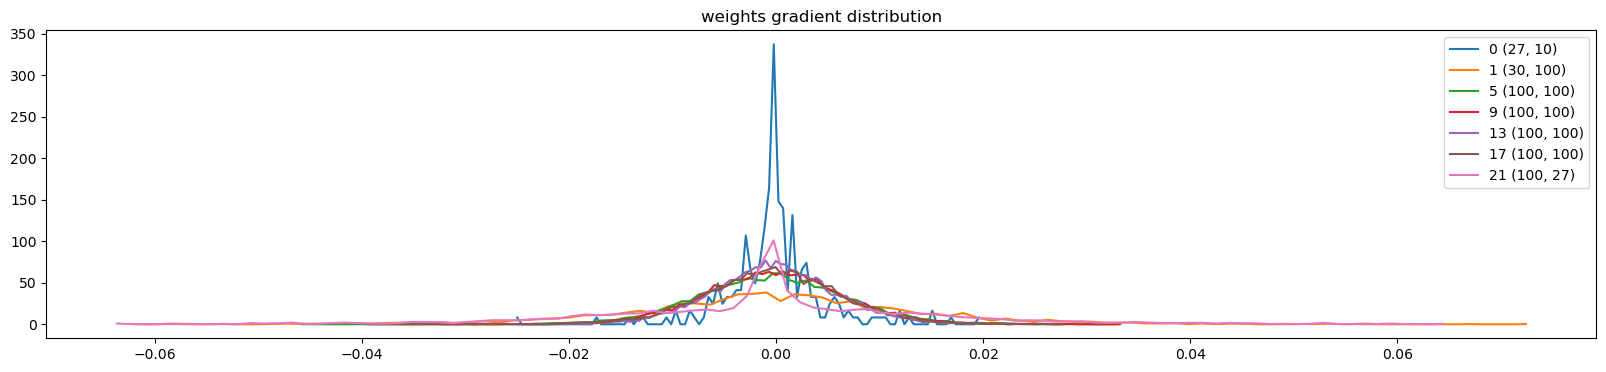

In [107]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:  # considering only weights from linear layers + embedding layer
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

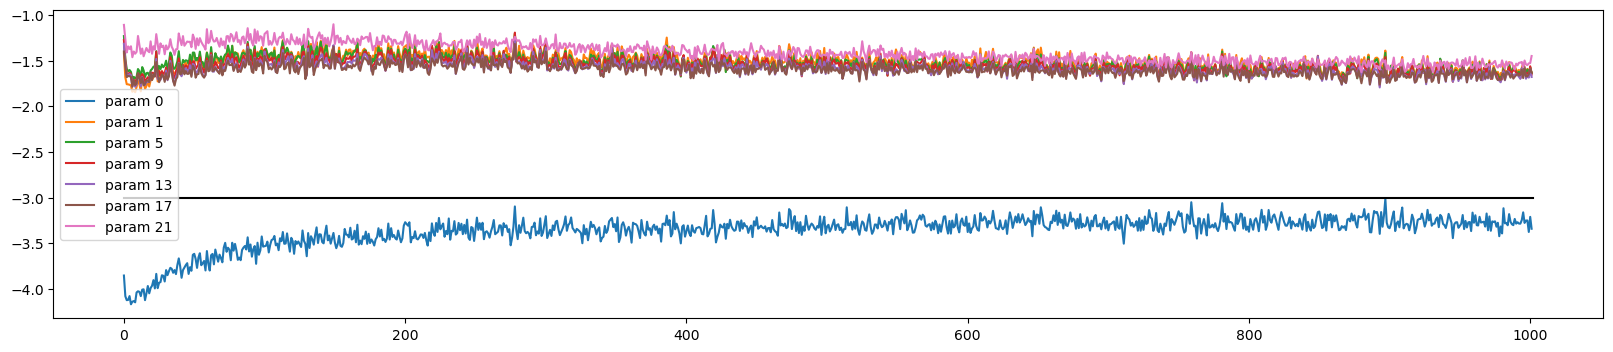

In [108]:
# another informative graph is grad update to data ratio (more informative)
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [109]:
# so even if we are set the `bad` factor at initializing weight, we are gonna be okay 
# because of BN
# so we have more robust forward and backward behavior

# but we are still have to be careful with grad update to data ratio, and need to accordingly adjust it
# (this will be no problem if we use Adam)